In [215]:
import pandas as pd
import numpy as np
import gensim
import nltk
import re
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer


from nltk.cluster import KMeansClusterer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [204]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chucho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/chucho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [205]:
openvas_df = pd.read_json('OpenvasLookup.json')
openvas_df_vulns = openvas_df.query('cvss != 0.0') # Filter info vulns

In [206]:
openvas_df_vulns['plugin_name_lowered'] = openvas_df_vulns['plugin_name'].str.lower()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [207]:
openvas_df_vulns[['plugin_name_lowered']].sample(5)

plugin_name_lowered
20903                ubuntu update for puppet usn-1419-1
25072  microsoft windows unhookwindowshookex local do...
40292  bws systems ha-bridge #!/system uri informatio...
17689  debian security advisory dsa 3213-1 (arj - sec...
40734                  ubuntu update for gcab usn-3546-1

In [208]:
document = 'Testing the fucking stop words, like at, or, it, a, for. I don\'t fucking know'
tokens = [nltk.word_tokenize(t) for t in nltk.sent_tokenize(document.lower()) if t not in nltk.corpus.stopwords.words('english')]
tokens2 = [nltk.word_tokenize(t) for t in nltk.sent_tokenize(openvas_df_vulns['plugin_name_lowered'][29751])]
filtered_words = [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
filtered_words2 = [word for word in tokens2 if word not in nltk.corpus.stopwords.words('english')]

In [209]:
tokens = nltk.word_tokenize(openvas_df_vulns['plugin_name_lowered'][29751])
filtered_words = [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
filtered_words

def filter_stopwords(tokens):
    filtered_words = [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
    return ' '.join(filtered_words)

def clean_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)
    return re.sub(r'\s{2,}', ' ', sentence)

def build_phrases(sentences):
    phrases = Phrases(sentences,
                      min_count=1,
                      threshold=5,
                      progress_per=1000)
    return Phraser(phrases)

def sentence_to_bi_grams(phrases_model, sentence):
    return ' '.join(phrases_model[sentence])

In [210]:
openvas_df_vulns['plugin_name_lowered'] = openvas_df_vulns['plugin_name_lowered'].apply(clean_sentence)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [211]:
openvas_df_vulns['plugin_name_tokenized'] = openvas_df_vulns['plugin_name_lowered'].apply(nltk.word_tokenize)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [212]:
openvas_df_vulns['plugin_name_cleaned'] = openvas_df_vulns['plugin_name_tokenized'].apply(filter_stopwords)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [213]:
openvas_df_vulns.sample(5)

creation_date                                                cve  \
11112  2005-11-03 14:08:04                                                 []   
21724  2012-07-30 16:41:12  [CVE-2011-3101, CVE-2012-1937, CVE-2012-1938, ...   
46939  2016-06-01 05:24:18  [CVE-2016-1581, CVE-2016-1582, CVE-2016-1581, ...   
8052   2014-11-20 17:12:57                                    [CVE-2014-4975]   
5423   2015-09-08 13:23:09                                    [CVE-2013-2094]   

       cvss                 cvss_vector  \
11112   7.8  AV:N/AC:L/Au:N/C:N/I:N/A:C   
21724  10.0  AV:N/AC:L/Au:N/C:C/I:C/A:C   
46939   2.1  AV:L/AC:L/Au:N/C:P/I:N/A:N   
8052    5.0  AV:N/AC:L/Au:N/C:P/I:N/A:N   
5423    7.2  AV:L/AC:L/Au:N/C:C/I:C/A:C   

                                              filename last_modification_date  \
11112                             nortel_pwdless2.nasl    2019-02-13 11:02:56   
21724           gb_CESA-2012_0710_firefox_centos6.nasl    2019-03-15 13:50:48   
46939                        gb_ubuntu_USN_2988_1.nasl    2019-03-13 13:26:09   
8052   gb_ruby_encodes_denial_of_service_vuln_win.nasl    2018-10-19 08:22:46   
5423                                alas-2013-190.nasl    2018-10-01 10:05:31   

          oid                                        plugin_name  \
11112   10529   Nortel Networks passwordless router (user level)   
21724  881200   CentOS Update for firefox CESA-2012:0710 centos6   
46939  842777                   Ubuntu Update for lxd USN-2988-1   
8052   804887  Ruby encodes function Denial-of-Service Vulner...   
5423   120302            Amazon Linux Local Check: ALAS-2013-190   

       script_category                       script_family  \
11112       ACT_ATTACK                    Default Accounts   
21724  ACT_GATHER_INFO        CentOS Local Security Checks   
46939  ACT_GATHER_INFO        Ubuntu Local Security Checks   
8052   ACT_GATHER_INFO                   Denial of Service   
5423   ACT_GATHER_INFO  Amazon Linux Local Security Checks   

                                    solution_from_plugin solution_type  \
11112  Telnet to this router and set a password immed...    Mitigation   
21724               Please install the updated packages.     VendorFix   
46939               Please Install the Updated Packages.     VendorFix   
8052                     Upgrade to Ruby 2.1.3 or later.     VendorFix   
5423   Run yum update kernel to update your system.  ...     VendorFix   

                                                    text  \
11112  script_oid("1.3.6.1.4.1.25623.1.0.10529");\n  ...   
21724  script_xref(name:"URL", value:"http://lists.ce...   
46939  script_oid("1.3.6.1.4.1.25623.1.0.842777");\n ...   
8052   CPE = "cpe:/a:ruby-lang:ruby";\n\n\n\n  script...   
5423   script_oid("1.3.6.1.4.1.25623.1.0.120302");\n ...   

                                     plugin_name_lowered  \
11112     nortel networks passwordless router user level   
21724     centos update for firefox cesa20120710 centos6   
46939                     ubuntu update for lxd usn29881   
8052   ruby encodes function denialofservice vulnerab...   
5423                amazon linux local check alas2013190   

                                   plugin_name_tokenized  \
11112  [nortel, networks, passwordless, router, user,...   
21724  [centos, update, for, firefox, cesa20120710, c...   
46939               [ubuntu, update, for, lxd, usn29881]   
8052   [ruby, encodes, function, denialofservice, vul...   
5423          [amazon, linux, local, check, alas2013190]   

                                     plugin_name_cleaned  
11112     nortel networks passwordless router user level  
21724         centos update firefox cesa20120710 centos6  
46939                         ubuntu update lxd usn29881  
8052   ruby encodes function denialofservice vulnerab...  
5423                amazon linux local check alas2013190

In [217]:
vectorizer = TfidfVectorizer()
tfs = vectorizer.fit_transform(openvas_df_vulns['plugin_name_cleaned'].values)

In [218]:
true_k = 10
test_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
test_model.fit(tfs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=10, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
New_X = tfs.todense()
clusters = test_model.labels_.tolist()
pca = PCA(n_components= 2).fit(New_X)
data2D = pca.transform(New_X)
plt.scatter(data2D[:,0], data2D[:,1], c=clusters);

In [67]:
model = Word2Vec(openvas_df_vulns['plugin_name_cleaned'].values,)
#documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
#model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)


In [83]:
x = model[model.wv.vocab]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [84]:
print(x)

[[-0.0473413  -0.14338356 -0.00650453 ... -0.04075044  0.0197067
  -0.00145625]
 [-0.11792474 -0.28187928 -0.02932413 ... -0.09495223  0.04072531
  -0.03564281]
 [-0.12629212 -0.29037493 -0.01310083 ... -0.06259557  0.06232323
  -0.00462234]
 ...
 [-0.03145031 -0.05644918 -0.00587451 ... -0.02299677 -0.01371747
   0.03543362]
 [-0.02059922 -0.02848817 -0.01496829 ... -0.01527232 -0.01076205
   0.02410646]
 [-0.02034017 -0.03396358  0.0077778  ...  0.00662601 -0.03024941
   0.03209769]]


In [69]:
pca = PCA(n_components=2)
result = pca.fit_transform(x)

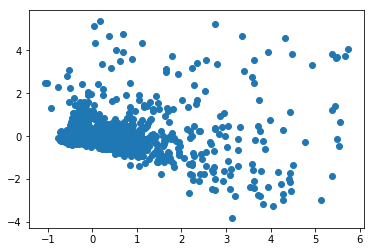

In [170]:
plt.scatter(result[:, 0], result[:, 1]);

In [191]:
print (model.wv.most_similar('fedora'))

[('suse', 0.9193436503410339), ('redhat', 0.8974363803863525), ('mandriva', 0.8947690725326538), ('ubuntu', 0.884636402130127), ('opensuse', 0.8783458471298218), ('simgear', 0.8584861755371094), ('cabextract', 0.8576732873916626), ('kdepimlibs', 0.8174847960472107), ('networkmanagervpnc', 0.8169330358505249), ('libkcddb', 0.8126142621040344)]


In [201]:
word_vectors = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors)

true_k = 10
test_model = KMeans(n_clusters=true_k)
test_model.fit(result)


validation_test = model[openvas_df_vulns['plugin_name_cleaned'][4992]]
pca_validation = PCA(n_components=2)
result_test = pca_validation.fit_transform(word_vectors)
test_prediction = test_model.fit_predict(result_test)

idx = test_model.fit_predict( word_vectors )
word_centroid_map = dict(zip( model.wv.index2word, idx ))
word_centroid_map_values = list(word_centroid_map.values())
word_centroid_map_keys = list(word_centroid_map.keys())

for cluster in range(0,10):

# Print the cluster number

    print("\nCluster %d" % cluster)

# Find all of the words for that cluster number, and print them out

    words = []

    for i in range(0,len(word_centroid_map_values)):

        if( word_centroid_map_values[i] == cluster ):

            words.append(word_centroid_map_keys[i])

    print(words)



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.



Cluster 0
['server', 'mozilla', 'lts', 'dla', 'google', 'gentoo', 'thunderbird', 'centos7', '01', 'bind', 'products', 'reader', 'internet', 'memory', 'vmware', 'x8664', 'request', 'password', 'nss', 'moodle', 'vulnerabilities02', 'ftp', 'framework', 'krb5', 'clamav', 'control', 'ms', 'fedora201411448', 'mediawiki', 'ruby', 'httpd', 'asterisk', 'dc', 'inclusion', 'within', 'core', 'gnutls', 'graphicsmagick', 'client', 'services', 'mariadb', 'track', 'handling', 'python', 'network', 'libtiff', 'pythondjango', 'spoofing', 'jan16', 'owncloud', 'path', 'html', 'xml', 'tiff', 'feature', 'vulnerability01', 'denialofservice', '1', 'open', '13', 'browser', 'libpng', 'vulnerabilities03', 'feb16', 'fedora2016cef912e3a4', 'login', 'otrs', 'systemd', 'allow', 'fedora201113417', 'poppler', 'insecure', 'isc', 'bind9', '03', 'gateway', 'macosx', 'ip', 'active', 'quagga', 'novell', 'puppet', 'chromiumbrowser', 'gnupg', 'input', 'ssh', 'wget', 'edge', 'compatibility', 'spice', 'pdf', 'files', 'depth', 

In [172]:
test_model.labels_

array([6, 0, 0, ..., 6, 6, 6], dtype=int32)

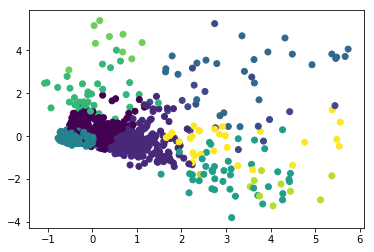

In [190]:
plt.scatter(result[:, 0], result[:, 1], c=test_model.labels_);